# Imports

In [1]:
#!pip install tensorflow

In [2]:
#!pip install keras

In [3]:
#!pip install keras --upgrade

In [4]:
#!pip install librosa==0.9.2


In [5]:
import os
import math
import wave
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras.layers import Embedding,LSTM,GRU,Dense,MaxPooling1D,Dropout
from tensorflow.keras.layers import LeakyReLU,ReLU,Flatten,concatenate,Bidirectional,TimeDistributed
from tensorflow.keras.layers import add,Conv1D,SeparableConv1D, GlobalMaxPooling2D,GlobalMaxPooling1D
from tensorflow.keras.layers import Conv2D,Input,Activation,BatchNormalization,MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.layers import concatenate
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.applications.densenet import DenseNet201




from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

C:\Users\USER\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Data Preprocessing

In [6]:
os.listdir('C:/Users/USER/Desktop/jupyter/respiratory-sound-database')

df_no_diagnosis = pd.read_csv('C:/Users/USER/Desktop/jupyter/respiratory-sound-database/demographic_info.txt', 
                              names=['Patient number', 'Age', 'Sex', 'Adult BMI (kg/m2)', 'Child Weight (kg)', 'Child Height (cm)'],
                              delimiter=' ')

diagnosis = pd.read_csv('C:/Users/USER/Desktop/jupyter/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', 
                        names=['Patient number', 'Diagnosis'])

In [7]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [8]:
root = 'C:/Users/USER/Desktop/jupyter/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'

filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

## Read Respiratory Cycle Data

In [9]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [10]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

my_index = pd.Series(list(rec_annotations_dict.keys()))

## Get Respiratory Cycle Wheezes and Crackles

In [11]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f[:3])

In [12]:
file_label_df = pd.DataFrame(data = {'filename':filename_list, 'no label':no_label_list, 'crackles only':crack_list, 'wheezes only':wheeze_list, 'crackles and wheezees':both_sym_list})

In [13]:
lables = file_label_df
lables.sort_values(by=['filename'])
sum = lables.groupby('filename').sum()

In [14]:
conditions = [
    (sum['crackles only'] == 0) & (sum['wheezes only'] == 0) & (sum['crackles and wheezees'] == 0),
    (sum['crackles only'] == sum.max(axis=1)),
    (sum['wheezes only'] == sum.max(axis=1)),
    (sum['crackles and wheezees'] == sum.max(axis=1)),
    (sum['no label'] == sum.max(axis=1)) & (sum['crackles only'] > sum['wheezes only']) & (sum['crackles only'] > sum['crackles and wheezees']),
    (sum['no label'] == sum.max(axis=1)) & (sum['wheezes only'] >= sum['crackles only']) & (sum['wheezes only'] > sum['crackles and wheezees']),
    (sum['no label'] == sum.max(axis=1)) & (sum['crackles and wheezees'] >= sum['crackles only']) & (sum['crackles and wheezees'] >= sum['wheezes only']),
]

values = ['Healthy' , 'Crackles' , 'Wheezes','Wheezes & Crackles', 'Crackles' , 'Wheezes','Wheezes & Crackles']
sum = lables.groupby('filename').sum()
sum['diagnosis'] = np.select(conditions, values)
sum

,no label,crackles only,wheezes only,crackles and wheezees,diagnosis
filename,,,,,
101,23,0,0,0,Healthy
102,13,0,0,0,Healthy
103,2,0,4,0,Wheezes
104,44,1,10,0,Wheezes
105,8,0,0,0,Healthy
...,...,...,...,...,...
222,24,13,8,0,Crackles
223,29,19,13,0,Crackles
224,14,0,0,0,Healthy


Crackles              50
Wheezes               36
Healthy               34
Wheezes & Crackles     6
Name: diagnosis, dtype: int64

Crackles              39.682540
Wheezes               28.571429
Healthy               26.984127
Wheezes & Crackles     4.761905
Name: diagnosis, dtype: float64


C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


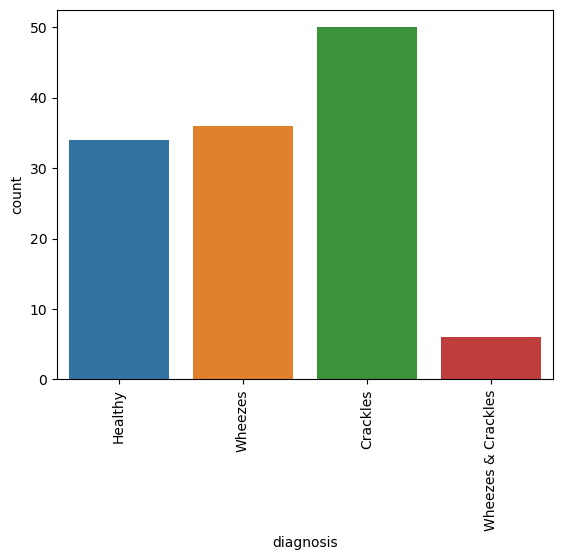

In [15]:
print (sum.diagnosis.value_counts())
print ('')
print (sum.diagnosis.value_counts(normalize=True) *100)

import seaborn as sns
sns.countplot(sum.diagnosis)
my_plt = plt.xticks(rotation=90)

## Save Diagnosis Data

In [16]:
#pip install resampy

In [17]:
sum.diagnosis.to_csv('C:/Users/USER/Desktop/jupyter/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/wheezes_crackles_diagnosis.csv')

## Data Augmentation

In [18]:
audio_data = 'C:/Users/USER/Desktop/jupyter/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'

In [19]:
diagnosis_df = pd.read_csv('C:/Users/USER/Desktop/jupyter/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/wheezes_crackles_diagnosis.csv', names=['patient_id', 'disease'],header=0)
diagnosis_df.head(4)

,patient_id,disease
0,101,Healthy
1,102,Healthy
2,103,Wheezes
3,104,Wheezes


In [20]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [21]:
def mfcc_feature_exteraction_wheezes(dir_):
    X_=[]
    y_=[]
    crackles=[]
    crackles_count=0
    data = diagnosis_df
    features = 52
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav':
            
            p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]

            if (p=='Crackles'):
                if (soundDir[:7] in crackles) and crackles_count<2:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    crackles.append(soundDir[:7])
                    crackles_count+=1
                    X_.append(mfccs)
                    y_.append('Not Wheezes')
                    
                    data_stretch = librosa.effects.time_stretch(data_x, rate=1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                    X_.append(mfccs_stretch)
                    y_.append('Not Wheezes')

                if (soundDir[:7] not in crackles):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    crackles.append(soundDir[:7])
                    crackles_count=0
                    X_.append(mfccs)
                    y_.append('Not Wheezes')
                    
                    data_stretch = librosa.effects.time_stretch(data_x, rate=1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                    X_.append(mfccs_stretch)
                    y_.append('Not Wheezes')
                    
            if (p == 'Wheezes'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append('Wheezes')
                
                data_stretch = librosa.effects.time_stretch(data_x, rate=1.2)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch)
                y_.append('Wheezes')
                
                data_stretch_2 = librosa.effects.time_stretch(data_x, rate=0.8)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch)
                y_.append('Wheezes')
                
                
            if (p=='Wheezes & Crackles'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append('Not Wheezes')
                
            if (p == 'Healthy'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append('Not Wheezes')
                
                data_stretch = librosa.effects.time_stretch(data_x, rate=1.2)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch)
                y_.append('Not Wheezes')


    X_data = np.array(X_)
    y_data = np.array(y_)
    
    
    
    return X_data ,y_data

In [22]:
def mfcc_feature_exteraction_crackles(dir_):
    X_=[]
    y_=[]
    data = diagnosis_df
    features = 52
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav'and soundDir[:3]!='':
            
            p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]
            
            if (p=='Crackles'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                X_.append(mfccs)
                y_.append('Crackles')
                
                data_stretch = librosa.effects.time_stretch(data_x, rate=1.2)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch)
                y_.append('Crackles')
                    
            if (p == 'Wheezes'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append('Not Crackles')
                
                data_stretch = librosa.effects.time_stretch(data_x, rate=1.2)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch)
                y_.append('Not Crackles')
                
                data_stretch_2 = librosa.effects.time_stretch(data_x, rate=0.8)
                mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch_2)
                y_.append('Not Crackles')
                
            if (p=='Wheezes & Crackles'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append('Not Crackles')
                
                data_stretch = librosa.effects.time_stretch(data_x, rate=1.2)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch)
                y_.append('Not Crackles')
                    
            if (p == 'Healthy'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append('Not Crackles')
                
                data_stretch = librosa.effects.time_stretch(data_x, rate=1.2)
                mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch)
                y_.append('Not Crackles')
                
                data_stretch_2 = librosa.effects.time_stretch(data_x, rate=0.8)
                mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_stretch_2)
                y_.append('Not Crackles')

    X_data = np.array(X_)
    y_data = np.array(y_)
    
    
    
    return X_data ,y_data

In [23]:
crackles_features , crackles_lables = mfcc_feature_exteraction_crackles(audio_data)
wheezes_features , wheezes_lables = mfcc_feature_exteraction_wheezes(audio_data)

In [24]:
def augmented_lables_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()

    print (data_count)

In [25]:
wheezes_lables.shape[0]

1544

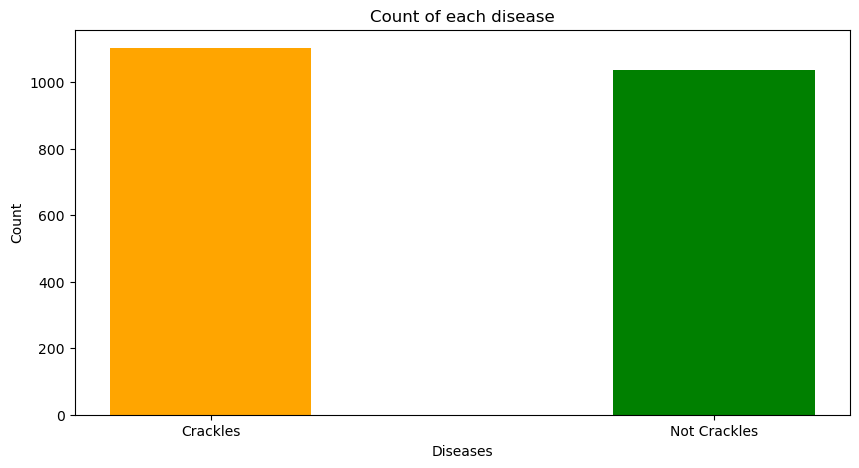

{'Crackles': 1102, 'Not Crackles': 1036}


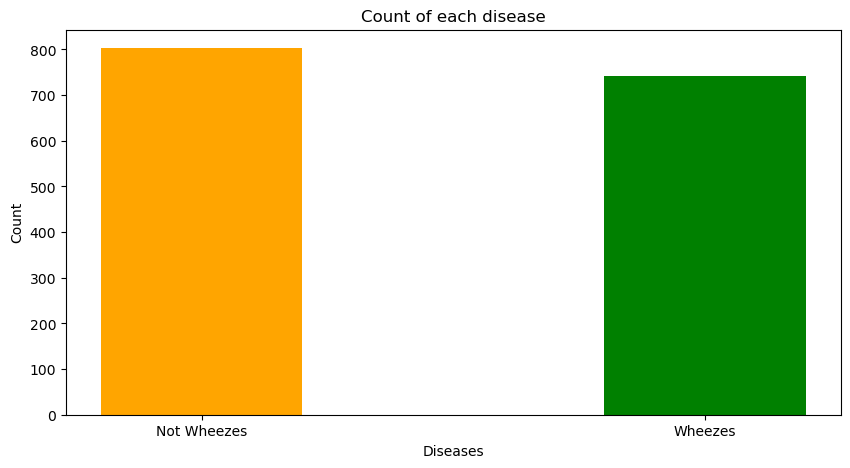

{'Not Wheezes': 803, 'Wheezes': 741}


In [26]:
augmented_lables_count(crackles_lables)
augmented_lables_count(wheezes_lables)

In [27]:
crackles_lables_encode = crackles_lables.reshape(crackles_lables.shape[0],1)
crackles_lables_encode = np.where(crackles_lables_encode == 'Crackles',np.array([1,0]).reshape(1,2) , crackles_lables_encode)
crackles_lables_encode = np.where(crackles_lables_encode == 'Not Crackles',np.array([0,1]).reshape(1,2) , crackles_lables_encode)


wheezes_lables_encode = wheezes_lables.reshape(wheezes_lables.shape[0],1)
wheezes_lables_encode = np.where(wheezes_lables_encode == 'Wheezes',np.array([1,0]).reshape(1,2) , wheezes_lables_encode)
wheezes_lables_encode = np.where(wheezes_lables_encode == 'Not Wheezes',np.array([0,1]).reshape(1,2) , wheezes_lables_encode)

crackles_lables = crackles_lables_encode.astype('float64')
wheezes_lables = wheezes_lables_encode.astype('float64')

In [28]:
x_crackles = np.array(crackles_features)
y_crackles = np.array(crackles_lables)

x_wheezes = np.array(wheezes_features)
y_wheezes = np.array(wheezes_lables)

print (x_crackles.shape , y_crackles.shape)
print (x_wheezes.shape , y_wheezes.shape)

(2138, 52) (2138, 2)
(1544, 52) (1544, 2)


## Data Split

In [29]:
c_x_train, c_x_val, c_y_train, c_y_val  = train_test_split(x_crackles,y_crackles, test_size=0.175, random_state=10)
c_x_train, c_x_test, c_y_train, c_y_test = train_test_split(c_x_train, c_y_train, test_size=0.075, random_state=10)

w_x_train, w_x_val, w_y_train, w_y_val  = train_test_split(x_wheezes, y_wheezes, test_size=0.175, random_state=10)
w_x_train, w_x_test, w_y_train, w_y_test = train_test_split(w_x_train, w_y_train, test_size=0.075, random_state=10)

print (c_x_train.shape, c_x_val.shape, c_x_test.shape)
print (c_y_train.shape, c_y_val.shape, c_y_test.shape)

print (w_x_train.shape, w_x_val.shape, w_x_test.shape)
print (w_y_train.shape, w_y_val.shape, w_y_test.shape)

(1630, 52) (375, 52) (133, 52)
(1630, 2) (375, 2) (133, 2)
(1177, 52) (271, 52) (96, 52)
(1177, 2) (271, 2) (96, 2)


# LSTM Model

## Build Model

In [30]:
model = Sequential()

model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())


model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(2, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 26, 2048)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 26, 2048)         8192      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 1024)         0         
 1D)                                                             
                                                        

In [31]:
#!pip install pydot

In [32]:
#!pip install graphviz


     -------------------------------------- 47.0/47.0 kB 294.4 kB/s eta 0:00:00


In [33]:
tf.keras.utils.plot_model(model, "LSTM_Model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [34]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Wheezes

In [35]:
w_x_train_lstm = np.expand_dims(w_x_train,axis=2)
w_x_val_lstm = np.expand_dims(w_x_val,axis=2)
w_x_test_lstm = np.expand_dims(w_x_test,axis=2)

## Train Model

In [36]:
w_model = model
w_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 26, 2048)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 26, 2048)         8192      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 1024)         0         
 1D)                                                             
                                                        

In [56]:
cb = [EarlyStopping(patience=10,monitor='val_accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("C:/Users/USER/Desktop/jupyter/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/W_LSTM_CNN_1.h5",save_best_only=True)]

In [57]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
w_model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
w_history = w_model.fit(w_x_train_lstm, w_y_train, batch_size=16, epochs=250, validation_data=(w_x_val_lstm, w_y_val),callbacks = cb )

Epoch 1/250
74/74 [==============================] - 148s 2s/step - loss: 0.5977 - accuracy: 0.6805 - val_loss: 0.6266 - val_accuracy: 0.6199
Epoch 2/250
74/74 [==============================] - 128s 2s/step - loss: 0.5818 - accuracy: 0.6754 - val_loss: 0.6205 - val_accuracy: 0.6531
Epoch 3/250
74/74 [==============================] - 130s 2s/step - loss: 0.5747 - accuracy: 0.7009 - val_loss: 0.9478 - val_accuracy: 0.4908
Epoch 4/250
74/74 [==============================] - 130s 2s/step - loss: 0.5468 - accuracy: 0.7052 - val_loss: 0.5916 - val_accuracy: 0.6937
Epoch 5/250
74/74 [==============================] - 132s 2s/step - loss: 0.5502 - accuracy: 0.7196 - val_loss: 0.7281 - val_accuracy: 0.5646
Epoch 6/250
74/74 [==============================] - 131s 2s/step - loss: 0.5292 - accuracy: 0.7324 - val_loss: 0.6106 - val_accuracy: 0.5941
Epoch 7/250
74/74 [==============================] - 130s 2s/step - loss: 0.4980 - accuracy: 0.7553 - val_loss: 0.7080 - val_accuracy: 0.6384
Epoch 

## Evaluate Model

9/9 [==============================] - 3s 308ms/step - loss: 0.6007 - accuracy: 0.6937


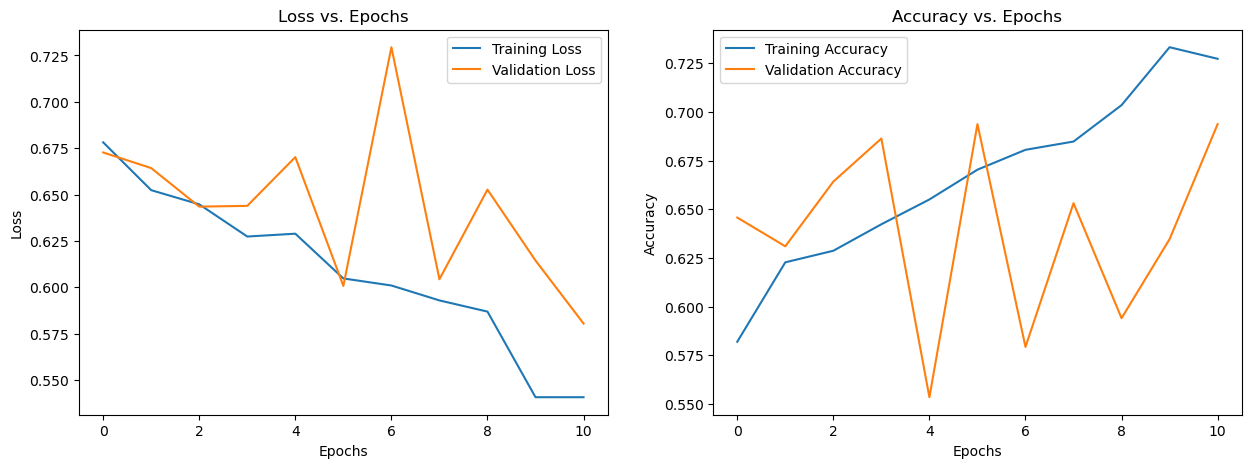

In [43]:
w_model.evaluate(w_x_val_lstm, w_y_val)
def plot_loss_curves(history):
    """
    Plots loss vs. epochs and accuracy vs. epochs curves for training and validation data.

    :param history: Training history from model.fit()
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(history.history['loss'], label='Training Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss vs. Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(history.history['accuracy'], label='Training Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy vs. Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()
    
plot_loss_curves(w_history)


## Results

3/3 [==============================] - 3s 351ms/step


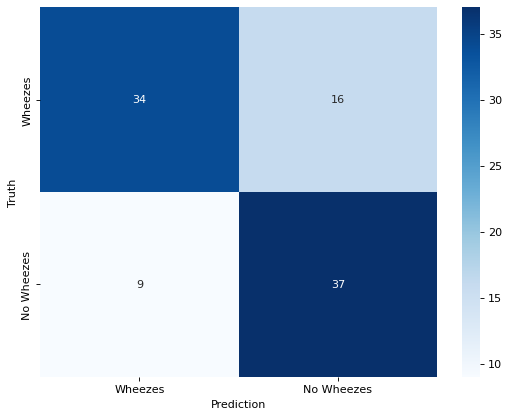

In [44]:
classes = ["Wheezes", "No Wheezes"]

preds = w_model.predict(w_x_test_lstm)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in w_y_test]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [45]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

     Wheezes       0.79      0.68      0.73        50
  No Wheezes       0.70      0.80      0.75        46

    accuracy                           0.74        96
   macro avg       0.74      0.74      0.74        96
weighted avg       0.75      0.74      0.74        96



In [46]:
w_model.save('C:/Users/USER/Desktop/jupyter/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/LSTM_W_97.78.h5')

# Prediction

In [54]:
def wheezes_detection(audio_path):
    w_classes = ["Wheezes", "No Wheezes"]

    data_x, sampling_rate = librosa.load(audio_path)

    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=52).T,axis = 0)

    features = features.reshape(1,52)

    w_pred = w_model.predict(np.expand_dims(features, axis = 2))
    w_classpreds = w_classes[np.argmax(w_pred, axis=1)[0]]
    w_confidence = w_pred.T[w_pred.mean(axis=0).argmax()].mean()

    print (w_classpreds, w_confidence)

In [55]:
wheezes_detection('C:/Users/USER/Desktop/jupyter/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/test/101_1b1_Pr_sc_Meditron.wav')

1/1 [==============================] - 0s 74ms/step
Wheezes 0.9169341
